In [1]:
# Importing required libraries 
# Keras
import keras
from keras import regularizers
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from keras.utils import np_utils, to_categorical
from keras.callbacks import ModelCheckpoint

# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# Import libraries 
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob 
import wave
from sklearn.metrics import confusion_matrix
import IPython.display as ipd 
import os
import pickle
import sys
import warnings
from tensorflow.python.keras import optimizers
import pyaudio
import h5py

# ignore warnings 
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
RAVDESS = "data/RAVDESS/"

In [3]:
# RAVDESS data handling
# 1.Get data of RAVESS

RAVDESS_list = os.listdir(RAVDESS)
RAVDESS_list.sort()

emotion = []
gender = []
path = []

for i in RAVDESS_list:
    folder_name = os.listdir(RAVDESS + i)
    for f in folder_name:
        part = f.split('.')[0].split('-')
        emotion.append(int(part[2]))
        temp = int(part[6])
        if temp%2 == 0:
            temp = "female"
        else:
            temp = "male"
        gender.append(temp)
        path.append(RAVDESS + i + '/' + f)
        
RAVDESS_data_frame = pd.DataFrame(emotion)
RAVDESS_data_frame = RAVDESS_data_frame.replace({1:'neutral', 2:'neutral', 3:'happy', 4:'sad', 5:'angry', 6:'fear', 7:'disgust', 8:'surprise'})
RAVDESS_data_frame = pd.concat([pd.DataFrame(gender),RAVDESS_data_frame],axis=1)
RAVDESS_data_frame.columns = ['gender','emotion']
RAVDESS_data_frame['labels'] = RAVDESS_data_frame.gender + '_' + RAVDESS_data_frame.emotion
RAVDESS_data_frame['source'] = 'RAVDESS'  
RAVDESS_data_frame = pd.concat([RAVDESS_data_frame,pd.DataFrame(path, columns = ['path'])],axis=1)
RAVDESS_data_frame = RAVDESS_data_frame.drop(['gender', 'emotion'], axis=1)
print(RAVDESS_data_frame.labels.value_counts())
RAVDESS_data_frame.head()
RAVDESS_data_frame.to_csv("Data_path.csv",index=False)

male_neutral       144
female_neutral     144
male_disgust        96
male_sad            96
male_fear           96
male_surprise       96
female_disgust      96
female_surprise     96
female_angry        96
female_sad          96
female_fear         96
male_happy          96
male_angry          96
female_happy        96
Name: labels, dtype: int64


299
265


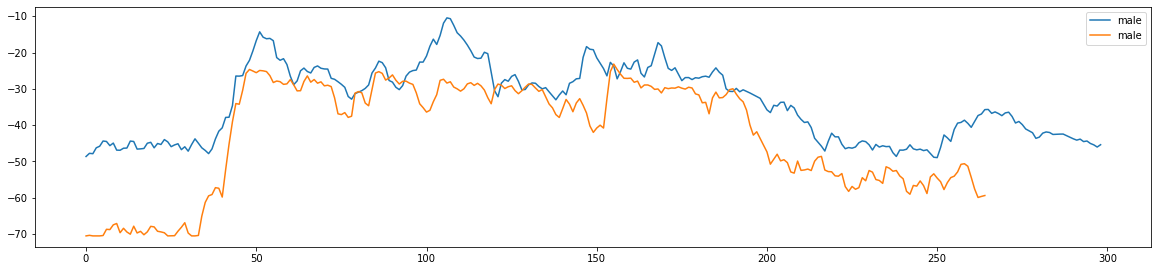

In [4]:
# Source - RAVDESS; Gender - Female; Emotion - Angry 
path = RAVDESS + "Actor_08/03-01-05-02-01-01-08.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=6,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Source - RAVDESS; Gender - Male; Emotion - Angry 
path = RAVDESS + "Actor_09/03-01-05-01-01-01-09.wav" 
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=6,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# audio wave
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='male')
plt.plot(male, label='male')
plt.legend()

216
216


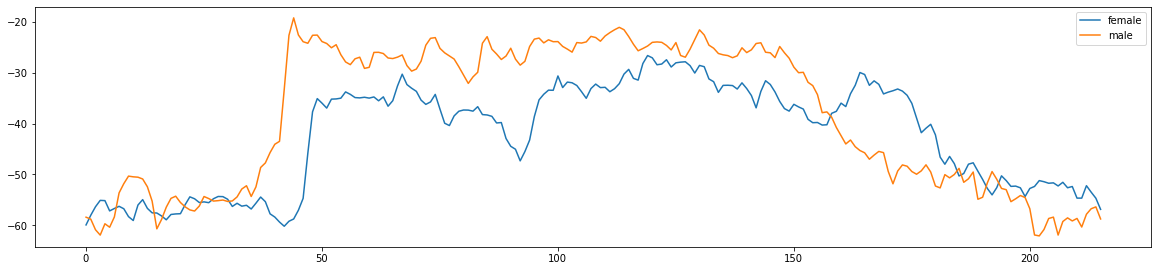

In [5]:
# Source - RAVDESS; Gender - Female; Emotion - happy 
path = RAVDESS + "Actor_12/03-01-03-01-02-01-12.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
female = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
female = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(female))

# Source - RAVDESS; Gender - Male; Emotion - happy 
path = RAVDESS +"Actor_11/03-01-03-01-02-02-11.wav"
X, sample_rate = librosa.load(path, res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)  
male = librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13)
male = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13), axis=0)
print(len(male))

# Plot the two audio waves together
plt.figure(figsize=(20, 15))
plt.subplot(3,1,1)
plt.plot(female, label='female')
plt.plot(male, label='male')
plt.legend()

In [6]:
ref = pd.read_csv("Data_path.csv")
ref.head()

,labels,source,path
0,male_neutral,RAVDESS,data/RAVDESS/Actor_01/03-01-01-01-01-01-01.wav
1,male_neutral,RAVDESS,data/RAVDESS/Actor_01/03-01-01-01-01-02-01.wav
2,male_neutral,RAVDESS,data/RAVDESS/Actor_01/03-01-01-01-02-01-01.wav
3,male_neutral,RAVDESS,data/RAVDESS/Actor_01/03-01-01-01-02-02-01.wav
4,male_neutral,RAVDESS,data/RAVDESS/Actor_01/03-01-02-01-01-01-01.wav


In [7]:
data_frame = pd.DataFrame(columns=['feature'])

# loop feature extraction over the entire dataset
counter=0
for index,path in enumerate(ref.path):
    X, sample_rate = librosa.load(path
                                  , res_type='kaiser_fast'
                                  ,duration=2.5
                                  ,sr=44100*2
                                  ,offset=0.5
                                 )
    sample_rate = np.array(sample_rate)
    
    # mean as the feature. Could do min and max etc as well. 
    mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                        sr=sample_rate, 
                                        n_mfcc=13),
                    axis=0)
    data_frame.loc[counter] = [mfccs]
    counter=counter+1   

# Check a few records to make sure its processed successfully
print(len(data_frame))
data_frame.head()

1440


,feature
0,"[-66.68597, -66.68597, -66.68597, -66.68597, -..."
1,"[-64.79551, -61.218655, -63.572693, -66.22239,..."
2,"[-66.98676, -66.98676, -66.98676, -66.98676, -..."
3,"[-66.507835, -66.507835, -66.507835, -66.50783..."
4,"[-70.70639, -70.70639, -70.70639, -70.70639, -..."


In [8]:
data_frame = pd.concat([ref,pd.DataFrame(data_frame['feature'].values.tolist())],axis=1)
data_frame[:5]

,labels,source,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430
0,male_neutral,RAVDESS,data/RAVDESS/Actor_01/03-01-01-01-01-01-01.wav,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-65.162041,-66.685966,-66.685966,-66.685966,...,-62.937782,-61.162216,-60.601204,-61.760639,-61.730015,-63.036179,-62.527000,-63.300228,-64.289330,-61.570652,-59.437031,-58.380531,-59.821144,-61.136295,-61.003006,-57.066422,-55.825516,-57.586800,-58.265377,-56.661026,-57.181091,-58.559017,-61.999958,-64.295670,-64.680878,-65.620522,-66.685966,-66.211456,-66.172989,-64.727524,-63.782047,-65.159958,-66.379623,-66.370964,-65.050102,-62.615089,-63.867981,-66.252884,-65.178276,-64.132698
1,male_neutral,RAVDESS,data/RAVDESS/Actor_01/03-01-01-01-01-02-01.wav,-64.795509,-61.218655,-63.572693,-66.222389,-66.224869,-63.284908,-60.982262,-59.693153,-62.967216,-65.062454,-60.944389,-62.944443,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.129272,-63.683353,-59.593410,-59.454838,-59.329189,-60.703369,-64.050865,-63.867638,-61.336868,-63.481865,-66.224869,-66.224869,-66.224869,...,-62.579815,-64.452148,-65.350327,-64.655861,-65.242851,-66.224869,-65.702179,-61.427471,-60.593246,-60.707478,-61.574791,-60.812584,-64.718208,-66.113914,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869
2,male_neutral,RAVDESS,data/RAVDESS/Actor_01/03-01-01-01-02-01-01.wav,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.298943,-66.685699,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.148026,-64.492401,-66.579010,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-64.854698,-66.210190,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.269943,-64.994888,-65.581924,...,-66.986763,-66.132355,-65.322136,-66.879128,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.760933,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-64.720276,-65.829056,-66.891724,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763
3,male_neutral,RAVDESS,data/RAVDESS/Actor_01/03-01-01-01-02-02-01.wav,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.407028,-65.926567,-66.062553,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,...,-66.507835,-66.507835,-66.484711,-66.111855,-65.111862,-64.931282,-64.957451,-66.485909,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-64.145638,-61.861534,-61.482262,-60.700748,-60.154221,-60.660282,-59.993748,-58.027817,-57.186775,-55.391930,-56.464668,-58.695942,-61.785606,-60.461224,-58.892254,-63.327183,-63.659512,-61.913033,-64.136932,-65.742035,-66.507835,-64.259415,-61.868252,-61.696602,-61.834988,-60.222519
4,male_neutral,RAVDESS,data/RAV

In [9]:
data_frame = data_frame.fillna(0)
print(data_frame.shape)
data_frame[:5]

(1440, 434)


,labels,source,path,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,...,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430
0,male_neutral,RAVDESS,data/RAVDESS/Actor_01/03-01-01-01-01-01-01.wav,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-66.685966,-65.162041,-66.685966,-66.685966,-66.685966,...,-62.937782,-61.162216,-60.601204,-61.760639,-61.730015,-63.036179,-62.527000,-63.300228,-64.289330,-61.570652,-59.437031,-58.380531,-59.821144,-61.136295,-61.003006,-57.066422,-55.825516,-57.586800,-58.265377,-56.661026,-57.181091,-58.559017,-61.999958,-64.295670,-64.680878,-65.620522,-66.685966,-66.211456,-66.172989,-64.727524,-63.782047,-65.159958,-66.379623,-66.370964,-65.050102,-62.615089,-63.867981,-66.252884,-65.178276,-64.132698
1,male_neutral,RAVDESS,data/RAVDESS/Actor_01/03-01-01-01-01-02-01.wav,-64.795509,-61.218655,-63.572693,-66.222389,-66.224869,-63.284908,-60.982262,-59.693153,-62.967216,-65.062454,-60.944389,-62.944443,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.129272,-63.683353,-59.593410,-59.454838,-59.329189,-60.703369,-64.050865,-63.867638,-61.336868,-63.481865,-66.224869,-66.224869,-66.224869,...,-62.579815,-64.452148,-65.350327,-64.655861,-65.242851,-66.224869,-65.702179,-61.427471,-60.593246,-60.707478,-61.574791,-60.812584,-64.718208,-66.113914,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869,-66.224869
2,male_neutral,RAVDESS,data/RAVDESS/Actor_01/03-01-01-01-02-01-01.wav,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.298943,-66.685699,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.148026,-64.492401,-66.579010,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-64.854698,-66.210190,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.269943,-64.994888,-65.581924,...,-66.986763,-66.132355,-65.322136,-66.879128,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.760933,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-64.720276,-65.829056,-66.891724,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763,-66.986763
3,male_neutral,RAVDESS,data/RAVDESS/Actor_01/03-01-01-01-02-02-01.wav,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.407028,-65.926567,-66.062553,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,...,-66.507835,-66.507835,-66.484711,-66.111855,-65.111862,-64.931282,-64.957451,-66.485909,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-66.507835,-64.145638,-61.861534,-61.482262,-60.700748,-60.154221,-60.660282,-59.993748,-58.027817,-57.186775,-55.391930,-56.464668,-58.695942,-61.785606,-60.461224,-58.892254,-63.327183,-63.659512,-61.913033,-64.136932,-65.742035,-66.507835,-64.259415,-61.868252,-61.696602,-61.834988,-60.222519
4,male_neutral,RAVDESS,data/RAV

In [10]:
# Split between train and test 
X_train, X_test, y_train, y_test = train_test_split(data_frame.drop(['path','labels','source'],axis=1)
                                                    , data_frame.labels
                                                    , test_size=0.25
                                                    , shuffle=True
                                                    , random_state=42
                                                   )
# Check the dataset now 
X_train.head()
X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430
168,-44.382664,-47.018936,-54.718075,-50.243736,-51.747402,-55.910515,-58.261299,-56.977737,-53.866367,-56.098293,-59.477947,-56.404922,-58.826412,-56.535954,-59.172337,-61.265526,-57.956638,-55.543617,-59.338902,-64.259178,-63.549004,-64.254753,-64.433060,-62.953243,-61.388271,-62.107742,-58.888512,-57.692226,-62.096134,-63.412849,-61.027832,-59.900528,-52.871201,-51.919998,-50.065090,-49.020115,-48.570190,-51.561089,-51.199883,-50.038898,...,-41.427715,-32.594826,-26.386412,-24.220821,-22.605299,-21.264397,-21.806084,-27.401638,-32.062874,-31.516350,-30.543936,-32.029819,-29.630198,-29.754499,-27.692211,-25.762169,-24.924746,-24.666063,-24.641752,-23.789059,-23.215214,-25.474846,-23.476057,-24.856129,-23.473925,-23.584064,-23.412830,-24.044271,-24.636690,-24.834093,-24.030037,-23.761675,-23.705111,-24.690458,-23.974962,-24.142874,-24.684908,-26.125843,-27.759472,-27.305826
605,-69.633110,-69.830307,-57.556004,-53.482651,-53.808090,-53.371056,-54.884232,-54.602116,-53.492924,-54.011311,-56.736633,-53.522007,-53.226601,-57.528877,-57.237991,-57.437538,-54.111130,-54.573067,-57.142559,-60.857735,-59.835674,-58.687771,-57.903603,-59.305645,-60.096760,-59.465561,-62.314480,-58.482868,-57.586899,-58.293133,-60.696491,-58.881916,-57.892460,-62.164577,-58.606647,-58.232918,-62.269409,-54.579758,-54.388710,-56.696857,...,-49.899960,-50.199852,-51.419258,-49.994446,-49.705681,-50.695816,-51.598007,-50.459572,-50.245220,-50.312664,-54.594261,-55.564499,-52.465996,-52.964756,-51.596848,-46.906490,-48.802303,-49.227146,-50.492516,-47.250263,-49.944515,-49.661552,-49.687866,-48.049850,-50.094563,-48.637150,-52.133041,-49.425480,-52.644863,-51.808712,-54.089188,-55.895615,-54.901390,-55.646564,-58.701538,-57.238113,-56.695328,-59.327534,-58.136230,-57.129715
548,-51.624596,-52.237976,-52.421047,-46.545433,-48.257938,-49.996357,-49.724094,-53.130497,-51.704124,-52.405331,-50.028416,-50.400394,-50.621910,-49.786621,-50.375309,-54.764412,-50.525898,-50.481094,-52.206478,-50.731323,-48.229233,-50.335648,-53.201748,-50.767796,-51.141174,-52.867886,-52.690529,-53.630325,-53.542263,-51.885822,-50.172073,-51.459679,-52.303719,-49.680832,-46.635704,-48.941704,-50.104065,-47.842960,-49.001095,-50.376713,...,-42.481056,-43.808777,-42.870598,-41.565483,-42.010471,-39.920940,-41.055099,-46.597054,-43.169453,-41.505142,-40.976231,-42.940720,-46.304642,-46.350246,-46.948250,-47.085838,-47.434044,-45.862801,-43.537247,-42.179417,-43.651360,-45.675102,-47.228447,-46.883518,-46.586613,-45.276485,-44.356770,-43.713707,-44.260674,-47.569088,-47.864788,-46.920864,-48.456944,-48.651222,-51.213448,-51.993599,-49.663742,-47.144775,-49.029716,-52.649437
65,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,-66.581444,...,-34.397480,-32.074104,-31.792711,-31.940401,-32.376198,-32.308334,-32.006058,-35.991978,-32.299667,-33.674324,-32.504498,-32.546875,-33.565838,-32.201931,-32.147995,-32.486225,-32.398865,-30.776550,-30.714354,-32.534206,-32.422409,-30.610386,-31.577282,-30.854910,-30.542660,-30.889065,-30.968689,-32.018497,-31.980904,-32.050430,-32.184643,-32.871849,-31.989889,-32.139725,-32.033432,-33.708683,-34.899204,-37.167942,-36.603119,-37.974979
628,-45.586433,-47.635994,-50.179520,-50.912094,-50.116760,-49.179470,-49.236221,-48.963261,-47.886662,-47.749001,-49.372829,-48.934147,-49.186893,-49.132828,-49.910271,-50.4

In [11]:
# Lts do data normalization 
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std

# Check the dataset now 
X_train.head()
X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430
168,1.422069,1.095086,0.216448,0.739628,0.548048,0.057818,-0.224314,-0.074326,0.295085,0.031048,-0.370761,-0.017369,-0.296916,-0.030671,-0.336513,-0.572636,-0.197699,0.075289,-0.358630,-0.928064,-0.862334,-0.941902,-0.948740,-0.778112,-0.608749,-0.696625,-0.325886,-0.206094,-0.714320,-0.840270,-0.571369,-0.456982,0.318657,0.410190,0.619006,0.731508,0.769024,0.437200,0.472434,0.603785,...,0.050324,0.740048,1.232840,1.413429,1.551703,1.673167,1.662882,1.257253,0.911033,0.969073,1.067662,0.967236,1.162188,1.161291,1.337163,1.504129,1.595416,1.640184,1.669252,1.752851,1.812253,1.646512,1.811884,1.702148,1.828442,1.833655,1.855127,1.827888,1.799151,1.793915,1.871969,1.916299,1.930007,1.866689,1.942290,1.938418,1.916531,1.819044,1.650641,1.434452
605,-1.473871,-1.582902,-0.124789,0.354127,0.305237,0.357450,0.176941,0.207883,0.339306,0.277622,-0.048093,0.322806,0.358889,-0.145336,-0.113196,-0.131922,0.247401,0.187247,-0.107269,-0.540497,-0.436919,-0.306952,-0.207615,-0.365645,-0.462391,-0.394192,-0.717041,-0.296341,-0.200477,-0.263388,-0.534351,-0.342495,-0.247285,-0.732957,-0.330485,-0.288037,-0.746544,0.103813,0.120961,-0.132464,...,-0.608001,-0.623512,-0.693272,-0.558527,-0.519673,-0.581182,-0.638500,-0.553083,-0.522653,-0.509395,-0.830376,-0.896300,-0.643537,-0.668112,-0.533272,-0.155133,-0.290214,-0.305438,-0.399129,-0.132349,-0.335620,-0.304002,-0.288150,-0.152268,-0.309701,-0.180888,-0.446149,-0.210981,-0.463358,-0.389256,-0.566869,-0.702910,-0.611386,-0.655114,-0.892077,-0.755273,-0.702835,-0.915805,-0.798045,-0.700013
548,0.591501,0.482386,0.492646,1.179807,0.959211,0.755632,0.790056,0.382702,0.551127,0.467366,0.741501,0.691146,0.663930,0.748756,0.679087,0.175832,0.662375,0.659279,0.457642,0.613325,0.892765,0.645661,0.326068,0.599804,0.552479,0.361002,0.381760,0.257550,0.260423,0.458579,0.641456,0.491728,0.382618,0.660049,1.000221,0.740185,0.599329,0.847836,0.714784,0.566429,...,-0.031524,-0.128505,-0.035509,0.086379,0.068498,0.244138,0.175924,-0.249827,0.035274,0.183381,0.244351,0.103283,-0.156332,-0.146765,-0.169539,-0.169207,-0.182162,-0.038929,0.157378,0.275114,0.170076,0.017482,-0.091106,-0.059016,-0.027946,0.089346,0.176943,0.247845,0.213920,-0.046125,-0.061854,0.028614,-0.086391,-0.085246,-0.280903,-0.328411,-0.127451,0.087698,-0.063964,-0.379364
65,-1.123880,-1.201495,-1.210022,-1.204914,-1.199846,-1.201250,-1.212892,-1.215185,-1.210573,-1.207521,-1.206881,-1.218167,-1.205123,-1.190746,-1.191880,-1.184653,-1.195981,-1.197986,-1.187504,-1.192667,-1.209744,-1.207276,-1.192592,-1.188384,-1.197252,-1.208701,-1.204215,-1.220750,-1.225436,-1.197302,-1.191828,-1.207884,-1.226614,-1.225815,-1.216973,-1.211936,-1.223592,-1.221672,-1.222922,-1.225518,...,0.596600,0.780379,0.816861,0.822799,0.804879,0.827238,0.874949,0.582804,0.892362,0.799333,0.912935,0.926294,0.850980,0.968388,0.988517,0.976471,1.005178,1.156138,1.183369,1.050144,1.072395,1.232362,1.162831,1.222526,1.260688,1.246253,1.249696,1.187319,1.205884,1.209866,1.210349,1.173737,1.255090,1.259843,1.284561,1.159836,1.080710,0.909498,0.937750,0.670872
628,1.284010,1.022645,0.762171,0.660079,0.740187,0.852017,0.848024,0.877742,1.003173,1.017504,0.818667,0.864159,0.831987,0.824258,0.732775,0.667299,0.405530,0.291194,0.432156,0.373107,0.043894,-0.177020,-0.163647,-0.110899,0.402660,0.567356,0.545461,0.530303,0.708952,0.800496,0.799430,0.847066,0.671275,-0.126326,-0.212869,-0.188682,-0.224271,0.175904,0.558542,0.674102,...,-0.057816,0.114384,0.000831,0.071970,0.067356,0.001282,-0.028844,-0.315269,-0.175545,-0.078625,-0.184894,0.029539,-0.150259,0.037759,0.015343,-0.216652,-0.095644,-0.032817,-0.217619,-0.034995,0.023674,0.103693,0.133483,-0.146252,-0.175578,-0.118543,-0.090646,-0.077800,-0.282529,0.005591

In [12]:
# Lets few preparation steps to get it into the correct format for Keras 
X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

# one hot encode the target 
lb = LabelEncoder()
y_train = np_utils.to_categorical(lb.fit_transform(y_train))
y_test = np_utils.to_categorical(lb.fit_transform(y_test))

print(X_train.shape)
print(lb.classes_)
# print(y_train[0:10])
# print(y_test[0:10])

# Pickel the lb object for future use 
filename = 'labels'
outfile = open(filename,'wb')
pickle.dump(lb,outfile)
outfile.close()

(1080, 431)
['female_angry' 'female_disgust' 'female_fear' 'female_happy'
 'female_neutral' 'female_sad' 'female_surprise' 'male_angry'
 'male_disgust' 'male_fear' 'male_happy' 'male_neutral' 'male_sad'
 'male_surprise']


In [13]:
X_train = np.expand_dims(X_train, axis=2)
X_test = np.expand_dims(X_test, axis=2)
X_train.shape

(1080, 431, 1)

In [14]:
model = Sequential()
model.add(Conv1D(256, 8, padding='same',input_shape=(X_train.shape[1],1)))  # X_train.shape[1] = No. of Columns
model.add(Activation('relu'))
model.add(Conv1D(256, 8, padding='same'))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(128, 8, padding='same'))
# model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))
model.add(MaxPooling1D(pool_size=(8)))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Conv1D(64, 8, padding='same'))
model.add(Activation('relu'))
model.add(Flatten())
model.add(Dense(14)) # Target class number
model.add(Activation('softmax'))
# opt = keras.optimizers.SGD(lr=0.0001, momentum=0.0, decay=0.0, nesterov=False)
# opt = keras.optimizers.Adam(lr=0.0001)
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 431, 256)          2304      
                                                                 
 activation (Activation)     (None, 431, 256)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 431, 256)          524544    
                                                                 
 activation_1 (Activation)   (None, 431, 256)          0         
                                                                 
 dropout (Dropout)           (None, 431, 256)          0         
                                                                 
 max_pooling1d (MaxPooling1D  (None, 53, 256)          0         
 )                                                               
                                                        

In [16]:
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=['accuracy'])
model_history=model.fit(X_train, y_train, batch_size=14, epochs=100, validation_data=(X_test, y_test))

Epoch 1/100
78/78 [==============================] - 42s 474ms/step - loss: 2.0975 - accuracy: 0.3120 - val_loss: 2.1879 - val_accuracy: 0.3194
Epoch 2/100
78/78 [==============================] - 43s 548ms/step - loss: 2.0499 - accuracy: 0.3139 - val_loss: 2.1262 - val_accuracy: 0.3306
Epoch 3/100
78/78 [==============================] - 39s 500ms/step - loss: 2.0065 - accuracy: 0.3250 - val_loss: 2.0899 - val_accuracy: 0.3417
Epoch 4/100
78/78 [==============================] - 35s 443ms/step - loss: 1.9818 - accuracy: 0.3370 - val_loss: 2.0827 - val_accuracy: 0.3556
Epoch 5/100
78/78 [==============================] - 38s 490ms/step - loss: 1.9483 - accuracy: 0.3352 - val_loss: 2.0533 - val_accuracy: 0.3389
Epoch 6/100
78/78 [==============================] - 39s 497ms/step - loss: 1.9243 - accuracy: 0.3370 - val_loss: 2.0334 - val_accuracy: 0.3444
Epoch 7/100
78/78 [==============================] - 39s 503ms/step - loss: 1.9016 - accuracy: 0.3417 - val_loss: 2.0314 - val_accuracy:

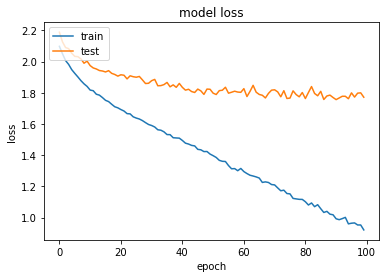

In [17]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [18]:
# Save model and weights
model_name = 'Emotion_Model.h5'
save_dir = os.path.join(os.getcwd(), 'saved_models')

if not os.path.isdir(save_dir):
    os.makedirs(save_dir)
model_path = os.path.join(save_dir, model_name)
model.save(model_path)
print('Save model and weights at %s ' % model_path)

# Save the model to disk
model_json = model.to_json()
with open('model_json.json', "w") as json_file:
    json_file.write(model_json)

Save model and weights at c:\Users\Administrator\00.Project\saved_models\Emotion_Model.h5 


In [19]:
# loading json and model architecture 
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model.h5")
print("Loaded model from disk")
 
# Keras optimiser
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
score = loaded_model.evaluate(X_test, y_test, verbose=0)
print("%s: %.2f%%" % (loaded_model.metrics_names[1], score[1]*100))

Loaded model from disk
accuracy: 39.17%


In [20]:
preds = loaded_model.predict(X_test, 
                         batch_size=14, 
                         verbose=1)

preds=preds.argmax(axis=1)
preds

26/26 [==============================] - 4s 133ms/step


array([ 8,  8,  1,  4,  9, 11,  4,  2,  6, 11,  1,  6, 11,  0, 11,  1,  0,
       13,  1,  1,  2,  4,  4, 13,  2,  8,  9,  7,  1,  8, 12,  7,  7,  7,
       11, 11,  1,  9,  2,  8, 12,  3,  5,  7, 10, 11,  4,  6,  1,  2, 12,
        6,  6,  8,  4, 11,  5,  6,  9, 12,  3,  1, 13,  6,  1,  6,  5,  8,
        6, 11,  6,  2,  4,  0,  8, 11,  8,  6, 11,  1, 10,  3,  7,  4,  5,
        7,  0, 12, 12,  5,  4,  4,  1,  7,  6,  8, 11,  8,  6, 11,  4,  2,
        9,  8, 11,  7,  1,  8,  9, 11,  2,  9,  2, 12, 12,  0,  0,  8,  3,
        9,  1,  5,  5,  7, 11,  7,  6, 11,  2,  9, 11,  8,  8, 11,  3,  1,
        4, 11,  1,  1,  8, 11,  3,  6,  3,  9,  7, 11,  9,  2,  7,  1,  4,
        9,  3, 11,  6, 11,  9,  6, 12,  8,  7,  8,  3,  6,  7,  5,  5,  6,
        4,  9,  2,  5,  7,  4,  7, 11, 13,  2,  3,  2,  3,  9,  4, 11,  9,
        9,  0,  7,  8,  2,  0,  4,  4,  6, 10,  6,  5,  5,  1,  8,  9,  5,
       11,  1,  8,  4, 10, 10,  7,  8,  6,  2,  4, 10,  0,  2,  6,  7,  1,
        2,  2,  2, 11,  4

In [21]:
# predictions 
preds = preds.astype(int).flatten()
preds = (lb.inverse_transform((preds)))
preds = pd.DataFrame({'predictedvalues': preds})

# Actual labels
actual=y_test.argmax(axis=1)
actual = actual.astype(int).flatten()
actual = (lb.inverse_transform((actual)))
actual = pd.DataFrame({'actualvalues': actual})

# Lets combined both of them into a single dataframe
finaldf = actual.join(preds)
finaldf[50:60]

,actualvalues,predictedvalues
50,male_sad,male_sad
51,female_surprise,female_surprise
52,male_surprise,female_surprise
53,female_angry,male_disgust
54,female_neutral,female_neutral
55,female_neutral,male_neutral
56,female_neutral,female_sad
57,female_surprise,female_surprise
58,male_happy,male_fear
59,male_neutral,male_sad


In [22]:
# Write out the predictions to disk
finaldf.to_csv('Predictions.csv', index=False)
finaldf.groupby('predictedvalues').count()

,actualvalues
predictedvalues,
female_angry,18
female_disgust,34
female_fear,26
female_happy,19
female_neutral,34
female_sad,24
female_surprise,34
male_angry,31
male_disgust,34


In [23]:
# the confusion matrix heat map plot
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
        
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Gender recode function
def gender(row):
    if row == 'female_disgust' or 'female_fear' or 'female_happy' or 'female_sad' or 'female_surprise' or 'female_neutral':
        return 'female'
    elif row == 'male_angry' or 'male_fear' or 'male_happy' or 'male_sad' or 'male_surprise' or 'male_neutral' or 'male_disgust':
        return 'male'

0.39166666666666666


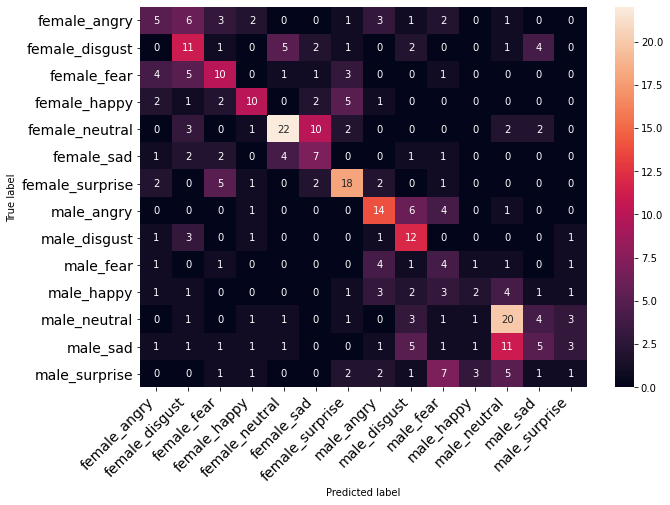

In [24]:
# Get the predictions file 
finaldf = pd.read_csv("Predictions.csv")
classes = finaldf.actualvalues.unique()
classes.sort()    

# Confusion matrix 
c = confusion_matrix(finaldf.actualvalues, finaldf.predictedvalues)
print(accuracy_score(finaldf.actualvalues, finaldf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [25]:
# Classification report 
classes = finaldf.actualvalues.unique()
classes.sort()    
print(classification_report(finaldf.actualvalues, finaldf.predictedvalues, target_names=classes))

                 precision    recall  f1-score   support

   female_angry       0.28      0.21      0.24        24
 female_disgust       0.32      0.41      0.36        27
    female_fear       0.38      0.40      0.39        25
   female_happy       0.53      0.43      0.48        23
 female_neutral       0.65      0.52      0.58        42
     female_sad       0.29      0.39      0.33        18
female_surprise       0.53      0.58      0.55        31
     male_angry       0.45      0.54      0.49        26
   male_disgust       0.35      0.63      0.45        19
      male_fear       0.16      0.29      0.21        14
     male_happy       0.25      0.11      0.15        19
   male_neutral       0.43      0.56      0.49        36
       male_sad       0.29      0.16      0.20        32
  male_surprise       0.10      0.04      0.06        24

       accuracy                           0.39       360
      macro avg       0.36      0.38      0.36       360
   weighted avg       0.39   

0.8638888888888889


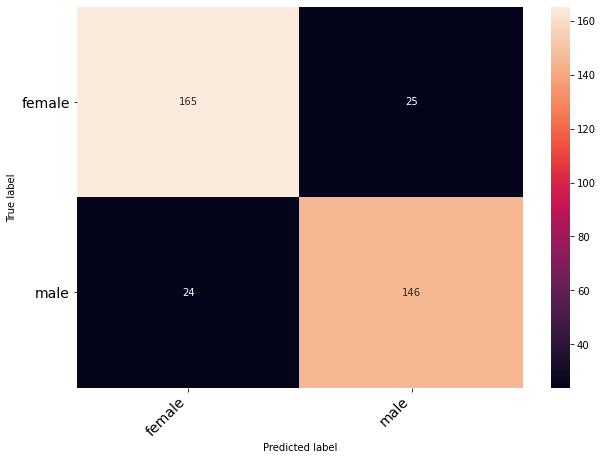

In [26]:
modidf = finaldf
modidf['actualvalues'] = finaldf.actualvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

modidf['predictedvalues'] = finaldf.predictedvalues.replace({'female_angry':'female'
                                       , 'female_disgust':'female'
                                       , 'female_fear':'female'
                                       , 'female_happy':'female'
                                       , 'female_sad':'female'
                                       , 'female_surprise':'female'
                                       , 'female_neutral':'female'
                                       , 'male_angry':'male'
                                       , 'male_fear':'male'
                                       , 'male_happy':'male'
                                       , 'male_sad':'male'
                                       , 'male_surprise':'male'
                                       , 'male_neutral':'male'
                                       , 'male_disgust':'male'
                                      })

classes = modidf.actualvalues.unique()  
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [27]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

      female       0.87      0.87      0.87       190
        male       0.85      0.86      0.86       170

    accuracy                           0.86       360
   macro avg       0.86      0.86      0.86       360
weighted avg       0.86      0.86      0.86       360



0.43333333333333335


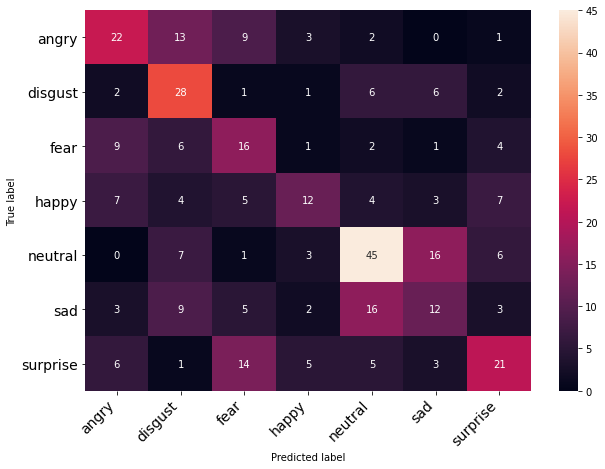

In [28]:
modidf = pd.read_csv("Predictions.csv")
modidf['actualvalues'] = modidf.actualvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

modidf['predictedvalues'] = modidf.predictedvalues.replace({'female_angry':'angry'
                                       , 'female_disgust':'disgust'
                                       , 'female_fear':'fear'
                                       , 'female_happy':'happy'
                                       , 'female_sad':'sad'
                                       , 'female_surprise':'surprise'
                                       , 'female_neutral':'neutral'
                                       , 'male_angry':'angry'
                                       , 'male_fear':'fear'
                                       , 'male_happy':'happy'
                                       , 'male_sad':'sad'
                                       , 'male_surprise':'surprise'
                                       , 'male_neutral':'neutral'
                                       , 'male_disgust':'disgust'
                                      })

classes = modidf.actualvalues.unique() 
classes.sort() 

# Confusion matrix 
c = confusion_matrix(modidf.actualvalues, modidf.predictedvalues)
print(accuracy_score(modidf.actualvalues, modidf.predictedvalues))
print_confusion_matrix(c, class_names = classes)

In [29]:
# Classification report 
classes = modidf.actualvalues.unique()
classes.sort()    
print(classification_report(modidf.actualvalues, modidf.predictedvalues, target_names=classes))

              precision    recall  f1-score   support

       angry       0.45      0.44      0.44        50
     disgust       0.41      0.61      0.49        46
        fear       0.31      0.41      0.36        39
       happy       0.44      0.29      0.35        42
     neutral       0.56      0.58      0.57        78
         sad       0.29      0.24      0.26        50
    surprise       0.48      0.38      0.42        55

    accuracy                           0.43       360
   macro avg       0.42      0.42      0.41       360
weighted avg       0.44      0.43      0.43       360



In [30]:
CHUNK = 1024 
FORMAT = pyaudio.paInt16
CHANNELS = 2 
RATE = 44100*2
RECORD_SECONDS = 4
WAVE_OUTPUT_FILENAME = "03-01-01-01-02-01-01.wav"

p = pyaudio.PyAudio()

stream = p.open(format=FORMAT,
                channels=CHANNELS,
                rate=RATE,
                input=True,
                frames_per_buffer=CHUNK) #buffer

print("* recording")

frames = []

for i in range(0, int(RATE / CHUNK * RECORD_SECONDS)):
    data = stream.read(CHUNK)
    frames.append(data) # 2 bytes(16 bits) per channel

print("* done recording")

stream.stop_stream()
stream.close()
p.terminate()

wf = wave.open(WAVE_OUTPUT_FILENAME, 'wb')
wf.setnchannels(CHANNELS)
wf.setsampwidth(p.get_sample_size(FORMAT))
wf.setframerate(RATE)
wf.writeframes(b''.join(frames))
wf.close()

* recording
* done recording


In [31]:
data, sampling_rate = librosa.load('03-01-01-01-02-01-01.wav')
ipd.Audio('03-01-01-01-02-01-01.wav')

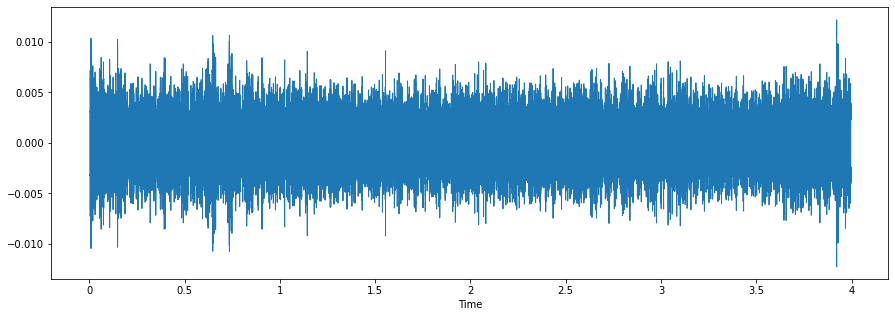

In [32]:
plt.figure(figsize=(15, 5))
librosa.display.waveshow(data, sr=sampling_rate)

In [33]:
# loading json and model architecture 
json_file = open('model_json.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# load weights into new model
loaded_model.load_weights("saved_models/Emotion_Model.h5")
print("Loaded model from disk")

# the optimiser
opt = keras.optimizers.RMSprop(lr=0.00001, decay=1e-6)
loaded_model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

Loaded model from disk


In [34]:
# Lets transform the dataset so we can apply the predictions
X, sample_rate = librosa.load('03-01-01-01-02-01-01.wav'
                              ,res_type='kaiser_fast'
                              ,duration=2.5
                              ,sr=44100*2
                              ,offset=0.5
                             )

sample_rate = np.array(sample_rate)
mfccs = np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=13),axis=0)
newdf = pd.DataFrame(data=mfccs).T
newdf

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,391,392,393,394,395,396,397,398,399,400,401,402,403,404,405,406,407,408,409,410,411,412,413,414,415,416,417,418,419,420,421,422,423,424,425,426,427,428,429,430
0,-23.942787,-23.291058,-28.664181,-30.05419,-33.611843,-31.386644,-31.452415,-28.656645,-29.52042,-29.716614,-30.381868,-32.684395,-31.342943,-30.162638,-28.848717,-28.350813,-27.951365,-28.387871,-26.793793,-28.011112,-25.886423,-27.073576,-28.962919,-30.360033,-25.803019,-23.565315,-25.319153,-26.833965,-29.374632,-30.057941,-28.939301,-30.602112,-32.127213,-35.575844,-29.881172,-31.373531,-30.999077,-29.451262,-27.474506,-25.417305,...,-32.812305,-35.239075,-33.590019,-30.604177,-29.341057,-31.058624,-29.550741,-28.710989,-28.147818,-30.289114,-30.63936,-30.235918,-33.087738,-33.655056,-34.085648,-33.262764,-34.755424,-33.322006,-34.374748,-32.912521,-33.792679,-36.008392,-39.925674,-37.95237,-35.512215,-32.71476,-32.384953,-33.656445,-30.609135,-32.018875,-33.017712,-30.078705,-28.383688,-33.392864,-30.159065,-29.960167,-32.724747,-35.403973,-35.035095,-28.533604


In [35]:
# Apply predictions
newdf= np.expand_dims(newdf, axis=2)
newpred = loaded_model.predict(newdf, 
                         batch_size=16, 
                         verbose=1)

newpred

1/1 [==============================] - 0s 201ms/step


array([[0.0000000e+00, 4.2562604e-20, 7.0185229e-02, 2.7556933e-18,
        9.2981428e-01, 4.5596602e-07, 1.0197502e-13, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.2703583e-14, 0.0000000e+00]], dtype=float32)

In [36]:
filename = 'labels'
infile = open(filename,'rb')
lb = pickle.load(infile)
infile.close()

# Get the final predicted label
final = newpred.argmax(axis=1)
final = final.astype(int).flatten()
final = (lb.inverse_transform((final)))
print(final) #emo(final) #gender(final) 

['female_neutral']
